In [1]:
import pandas as pd
import numpy as np

import scipy as sp
import sklearn as sk
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

import random
import time

import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output

In [2]:
#Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#set visual parameters
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 14,7

In [3]:
#common model algorithms
#common model algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
import tensorflow as tf
#from tensorflow import estimator
from sklearn.metrics import roc_curve, auc

#common model help tools
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

In [4]:
#import data
PATH1 = "C:/Users/kpunyakoti/Desktop/Data Science/Projects/AmEx Hack/Source/"   #where you read the files from
PATH2 = "C:/Users/kpunyakoti/Desktop/Data Science/Projects/AmEx Hack/Submissions/"   #where you export the files to

train = pd.read_csv(f'{PATH1}train.csv')
test = pd.read_csv(f'{PATH1}test.csv')
#Save the 'Id' column
train_ID = train['session_id']
test_ID = test['session_id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("session_id", axis = 1, inplace = True)
test.drop("session_id", axis = 1, inplace = True)

In [5]:
#concatenate train data and test data
ntrain = train.shape[0]
ntest = test.shape[0]

Target Variable
--

Treating outliers 
-- 
[always treat outliers first before treaing nulls]

CONCATENATE DATA

In [6]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.is_click.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['is_click'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (592149, 13)


In [7]:
all_data['DateTime'] = pd.to_datetime(all_data['DateTime'])
all_data['Hour'] = all_data['DateTime'].dt.hour
all_data['Date'] = all_data['DateTime'].dt.day
all_data['Day'] = all_data['DateTime'].dt.weekday

Handling Missing Data
--

In [157]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(10)

,Missing Ratio
product_category_2,74.647597
city_development_index,26.975981
user_group_id,4.040706
user_depth,4.040706
gender,4.040706
age_level,4.040706


Text(0.5,1,'Percent missing data by feature')

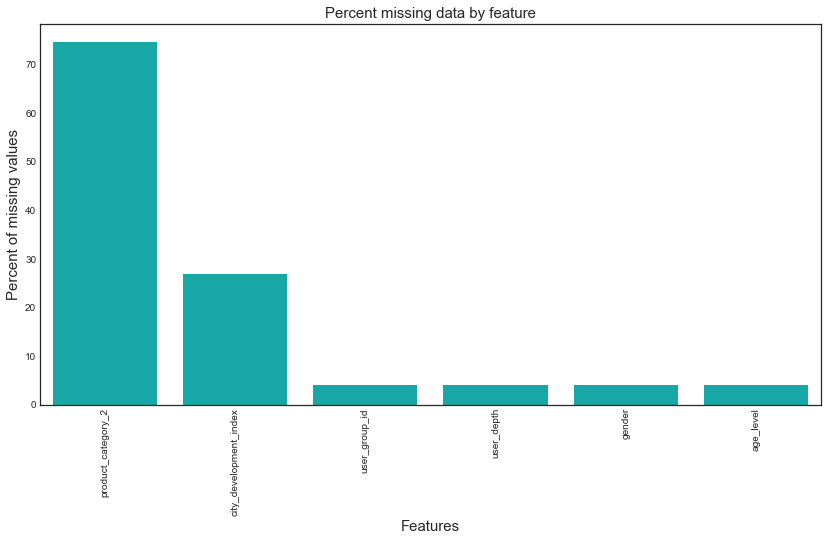

In [158]:
#plot missing data
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na, color="c")
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [160]:
#for user_depth - fill mode which is 3
all_data['user_depth'].fillna(3, inplace = True)

#for gender fill mode -first fill female
all_data.loc[((all_data.product == 'B')|(all_data.product == 'F') & all_data['gender'].isnull()==True), 'gender'] = 'Female'
#then rest nas with mode - male
all_data['gender'].fillna(all_data['gender'].mode()[0], inplace = True)

#for age_level
all_data['age_level'].fillna(3, inplace = True)

In [73]:
#for user_depth - fill mode Age values by sex and by title

all_data.loc[(all_data['Name'].str.contains('Miss|Ms') & all_data['Age'].isnull()==True), 'Age'] = 22
all_data.loc[(all_data['Name'].str.contains('Mr|Dr') & all_data['Age'].isnull()==True), 'Age'] = 29
all_data.loc[(all_data['Name'].str.contains('Mrs') & all_data['Age'].isnull()==True), 'Age'] = 35


#For Fare - Fill with median Fare by Pclass. Here pclass is 3 and median Fare for that Pclass is 8.05
all_data['Fare'].fillna(8.05, inplace = True) 

#for Embarked - two missing values fill with Mode
all_data['Embarked'].fillna(all_data['Embarked'].mode()[0], inplace = True)


In [18]:
#BsmtExposure-one row is marked NA(nobasement) where we have values for Basement:row-949-replace the value with mode which 'No'
#cond = ((str(all_data['BsmtQual'])!='None') & (str(all_data['BsmtExposure']) == 'None'))
#all_data.loc[cond,'BsmtExposure'] = 'No'

#BsmtFinType2-one row marked NA(nobasement) where we have values for Basement:row-333-replace the value with mode which is 'unf'
#cond2 = ((str(all_data['BsmtQual'])!='None') & (str(all_data['BsmtFinType2']) == 'None'))
#all_data.loc[cond2, 'BsmtFinType2'] = 'Unf'

In [19]:
#MSZoning - 4NAs -  impute using MSSubClass: where 20-MSz is RL, for 30-RM, 70-RM
#cond1 = ((all_data['MSZoning'].isnull()==True) & (str(all_data['MSSubClass']) == '20'))
#all_data.loc[cond1,'MSZoning'] = 'RL'
#cond2 = ((all_data['MSZoning'].isnull()==True) & (str(all_data['MSSubClass']) == '30'))
#all_data.loc[cond2,'MSZoning'] = 'RM'
#cond3 = ((all_data['MSZoning'].isnull()==True) & (str(all_data['MSSubClass']) == '70'))
#all_data.loc[cond3,'MSZoning'] = 'RM'

Drop Features
--

In [161]:
drop_cols = ['product_category_2', 'DateTime','city_development_index', 'user_group_id']   #
all_data.drop(drop_cols, axis=1, inplace=True)

In [162]:
#verify missing data
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


Convert Datatypes
--

In [163]:
cat_cols = ['webpage_id','user_id', 'campaign_id', 'product_category_1', 'age_level', 'user_depth']
for x in cat_cols:
    all_data[x] = all_data[x].astype('category')

Feature Engineering
--

In [164]:
cols = ['webpage_id','user_id', 'campaign_id', 'product_category_1', 'age_level', 'user_depth' , 'gender', 
        'product', 'Hour', 'Day', 'Date']
# Process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values)) 

In [165]:
#all_data = all_data.interpolate()
all_data = pd.get_dummies(all_data, sparse=True)
print(all_data.shape)
all_data.head()

(592149, 12)


,age_level,campaign_id,gender,product,product_category_1,user_depth,user_id,var_1,webpage_id,Hour,Date,Day
0,4,4,0,2,3,2,137427,0,3,0,0,6
1,2,2,0,2,4,1,41508,0,2,0,0,6
2,2,4,0,2,3,1,41508,0,3,0,0,6
3,3,4,1,8,2,2,171416,1,3,0,0,6
4,2,8,1,2,2,2,109538,1,8,0,0,6


In [166]:
#retrieve cleaned data to separate train/test sets for Machine Learning
train = all_data[:ntrain]
test = all_data[ntrain:]
print(train.shape)
print(test.shape)

(463291, 12)
(128858, 12)


In [167]:
clean_train.to_csv(f'{PATH2}train_data_cleaned.csv', index=False)
clean_test.to_csv(f'{PATH2}test_data_cleaned.csv', index=False)

In [143]:
imp_feat = ['Hour','product','webpage_id','age_level','gender','campaign_id', 'user_depth','product_category_1']

Machine Learning
--

Define a cross validation strategy

We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [168]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(train[imp_feat], 
                                                        y_train, train_size = 0.8, test_size = 0.2, random_state = 0)

Initializing Models
--

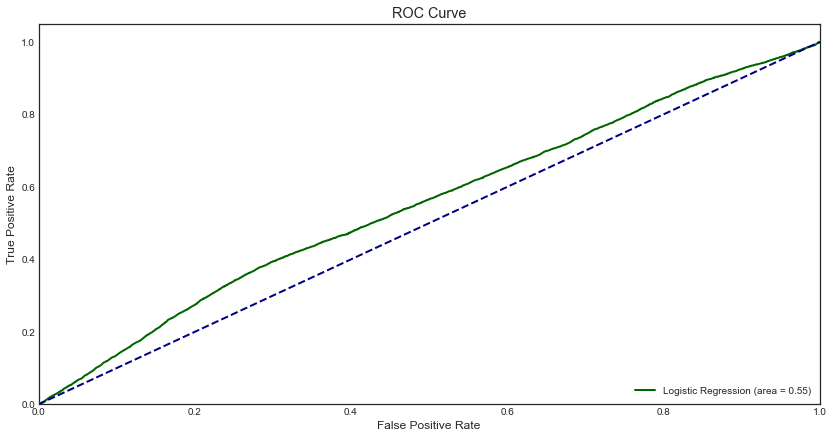

In [169]:
lr_model = linear_model.LogisticRegression(solver='sag')
lr_model.fit(train_x, train_y)

#y_predict = lr_model.predict(test_x)

lr_predict_probabilities = lr_model.predict_proba(test_x)[:,1]

lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_predict_probabilities)
lr_roc_auc = auc(lr_fpr, lr_tpr)

plt.figure()
#plt.plot(fpr, tpr, color='darkorange',
 #        lw=2, label='K-nearest Neighbours (area = %0.2f)' % roc_auc)
plt.plot(lr_fpr, lr_tpr, color='darkgreen',
         lw=2, label='Logistic Regression (area = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
GBoost = GradientBoostingClassifier()
GBoost.fit(train_x, train_y)

gb_predict_probabilities = GBoost.predict_proba(test_x)[:,1]

gb_fpr, gb_tpr, _ = roc_curve(test_y, gb_predict_probabilities)
gb_roc_auc = auc(gb_fpr, gb_tpr)

plt.figure()
plt.plot(gb_fpr, gb_tpr, color='darkorange',
         lw=2, label='GradientBoost (area = %0.2f)' % gb_roc_auc)
plt.plot(lr_fpr, lr_tpr, color='darkgreen',
         lw=2, label='Logistic Regression (area = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
sv = svm.SVC()
sv.fit(train_x, train_y)

#sv_predict_probabilities = sv.predict_proba(test_x)[:,1]

#sv_fpr, dt_tpr, _ = roc_curve(test_y, dt_predict_probabilities)
#sv_roc_auc = auc(sv_fpr, sv_tpr)


In [93]:
xgb = XGBClassifier()
xgb.fit(train_x, train_y)

xgb_predict_probabilities = xgb.predict_proba(test_x)[:,1]

xgb_fpr, xgb_tpr, _ = roc_curve(test_y, xgb_predict_probabilities)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)


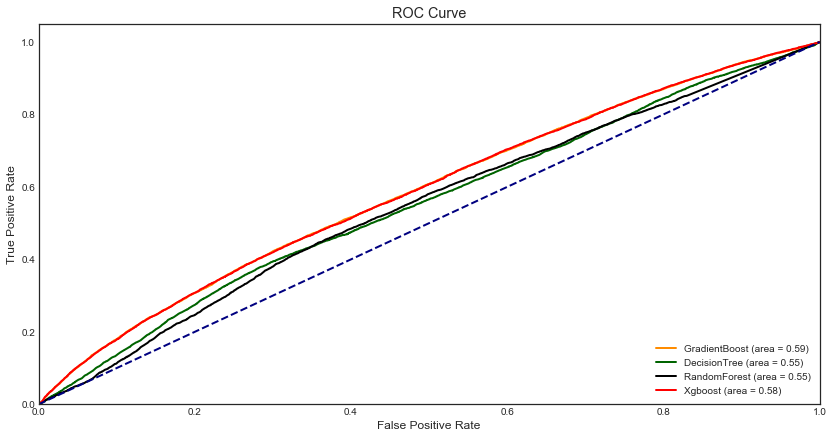

In [172]:
rf = RandomForestClassifier()
rf.fit(train_x, train_y)

rf_predict_probabilities = rf.predict_proba(test_x)[:,1]

rf_fpr, rf_tpr, _ = roc_curve(test_y, rf_predict_probabilities)
rf_roc_auc = auc(rf_fpr, rf_tpr)

plt.figure()
plt.plot(gb_fpr, gb_tpr, color='darkorange',
         lw=2, label='GradientBoost (area = %0.2f)' % gb_roc_auc)
plt.plot(lr_fpr, lr_tpr, color='darkgreen',
         lw=2, label='LogisticReg (area = %0.2f)' % dt_roc_auc)
plt.plot(rf_fpr, rf_tpr, color='black',
         lw=2, label='RandomForest (area = %0.2f)' % rf_roc_auc)
plt.plot(xgb_fpr, xgb_tpr, color='red',
         lw=2, label='Xgboost (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [82]:
def train_model(learning_rate, est):  
    lr = float(learning_rate)
    est = int(est)
    print('Training Model...')
    #grad3 = GradientBoostingRegressor(n_estimators = est, learning_rate = lr)
    xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=lr, max_depth=2, 
                             min_child_weight=1.7817, n_estimators=est,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1) 
    xgb.fit(train,y_train)
    xgb_pred = xgb.predict(train)
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train[imp_feat].values)
    score1= np.sqrt(-cross_val_score(xgb, train[imp_feat].values, y_train, scoring="neg_mean_squared_error", cv = kf))
    rmse1 = np.sqrt(mean_squared_error(y_train, xgb_pred))
    #print('Parametes:\n', xgb.get_params())
    print('Prev metrics: Score: 0.1182 (0.0056), rmse: 0.07816966100474533')
    print('\nNew score: {:.4f} ({:.4f})\n'.format(score1.mean(), score1.std()))
    print('New rmse: {} '.format(rmse1))    
    print("Model Training Completed")  
    return xgb

In [83]:
trained_model = train_model(learning_rate = 0.05,
                           est = 2200)   

Training Model...
Prev metrics: Score: 0.1182 (0.0056), rmse: 0.07816966100474533

New score: 0.1282 (0.0061)

New rmse: 0.08400227753743282 
Model Training Completed


                                            ---------------------------
                                            ---- END OF PLAYGROUND ----
                                            ---------------------------

In [36]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

Basemodel Scores
--

In [37]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0071)



In [38]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1115 (0.0071)



In [39]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1164 (0.0061)



In [40]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1170 (0.0075)



In [41]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1181 (0.0056)



In [42]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1175 (0.0067)



Stacking Models
--

AVERAGE BASED MODEL CLASS

In [43]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict_proba(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

AVERAGE MODELS' SCORE

In [44]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1091 (0.0068)



STACKING AVERAGED MODELS

In [45]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
 

STACKING AVERAGE MODELS SCORE

In [46]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1086 (0.0063)


In [47]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

Final Training and Predictions
--

In [48]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.08121435413608212


In [49]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07816979356357331


In [50]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07255079472019071


In [51]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.45 +
               xgb_train_pred*0.30 + lgb_train_pred*0.25 ))

RMSLE score on train data:
0.07513778957132955


In [52]:
ensemble = stacked_pred*0.40 + xgb_pred*0.35 + lgb_pred*0.25

In [128]:
#submit = pd.DataFrame()
#submit['Id'] = test.index
#submit['SalePrice'] = ensemble
preds = lr_model.predict(test[imp_feat])
submit = pd.DataFrame({'session_id': test_ID, 'is_click': preds})
submit.to_csv(f'{PATH2}submission_3.csv', index=False)